# Train a neural network model for audio authentication

<h2>1. Setup and import required libs</h2>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import audio_authentication as aau
from torch.utils.data import DataLoader

<h2>2. Loop over three generated dataset , train the model and evalute it</h2>

In [2]:
for dataset_no in range(3):
    
    print(f"Train a model on data_{dataset_no} :")
    
    train_dataset = aau.AudioDataset(data_dir=f'data_{dataset_no}/train')
    test_dataset = aau.AudioDataset(data_dir=f'data_{dataset_no}/test')

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    num_classes = len(train_dataset.label_encoder.classes_)
    model = aau.AudioClassifier(num_classes)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    aau.train(model, train_loader, criterion, optimizer, device)
    print("Training finished!",)
    aau.test(model, test_loader, device)
    print("**"*30)
    

Train a model on data_0 :
Epoch [1/10], Loss: 1.6197
Epoch [2/10], Loss: 0.9911
Epoch [3/10], Loss: 0.6359
Epoch [4/10], Loss: 0.3527
Epoch [5/10], Loss: 0.1499
Epoch [6/10], Loss: 0.0873
Epoch [7/10], Loss: 0.0953
Epoch [8/10], Loss: 0.0442
Epoch [9/10], Loss: 0.0250
Epoch [10/10], Loss: 0.0117
Training finished!
Accuracy: 73.88%
************************************************************
Train a model on data_1 :
Epoch [1/10], Loss: 1.7761
Epoch [2/10], Loss: 1.3550
Epoch [3/10], Loss: 0.8694
Epoch [4/10], Loss: 0.3820
Epoch [5/10], Loss: 0.1886
Epoch [6/10], Loss: 0.0939
Epoch [7/10], Loss: 0.0572
Epoch [8/10], Loss: 0.0540
Epoch [9/10], Loss: 0.0536
Epoch [10/10], Loss: 0.0292
Training finished!
Accuracy: 71.64%
************************************************************
Train a model on data_2 :
Epoch [1/10], Loss: 1.3954
Epoch [2/10], Loss: 0.9329
Epoch [3/10], Loss: 0.7777
Epoch [4/10], Loss: 0.6350
Epoch [5/10], Loss: 0.5038
Epoch [6/10], Loss: 0.3962
Epoch [7/10], Loss: 0.31

In [ ]:
#torch.save(model, 'audio_authentication.pth')
#model = torch.load('entire_model.pth')  # Load the entire model

<h2>3. Evaluate the results of our neural networks on test set</h2>

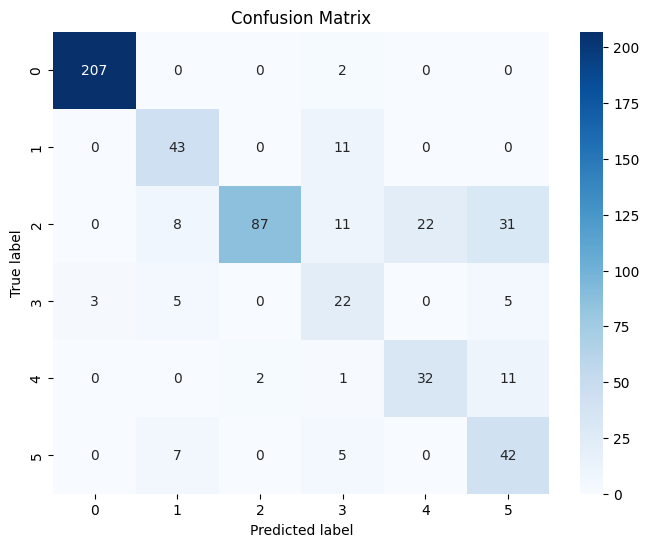

In [3]:
# Define required classes one more time to plot confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class TestAudioDataset(aau.AudioDataset):
    def __init__(self, data_dir):
        super().__init__(data_dir)

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

test_data_dir = 'data_2/test'
test_dataset = TestAudioDataset(test_data_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = 6


def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return all_labels, all_predictions

y_true, y_pred = evaluate_model(model, test_loader, device)

# Plot confusion matrix
classes = test_dataset.label_encoder.classes_
plot_confusion_matrix(y_true, y_pred, classes)

In [15]:
# Plot the AUC

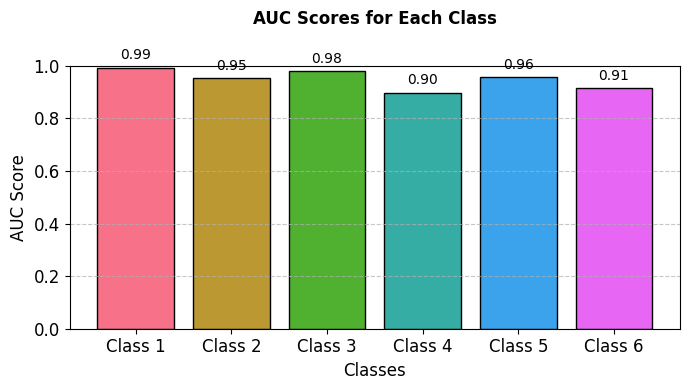

In [4]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Function to evaluate the model and get probabilities
def evaluate_model_with_probabilities(model, test_loader, device):
    model.eval()
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            probabilities = F.softmax(outputs, dim=1)  
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())

    return np.array(all_labels), np.vstack(all_probabilities)

# Run evaluation to get probabilities
y_true, y_prob = evaluate_model_with_probabilities(model, test_loader, device)

# Calculate AUC for each class
num_classes = 6
auc_scores = []
for i in range(num_classes):
    # Create a binary label for the current class
    binary_labels = (y_true == i).astype(int)
    auc = roc_auc_score(binary_labels, y_prob[:, i])
    auc_scores.append(auc)

# Plot AUC scores with styling
plt.figure(figsize=(7, 4))
bars = plt.bar(range(num_classes), auc_scores, color=sns.color_palette("husl", num_classes), edgecolor='black')

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding titles and labels
plt.ylim(0, 1)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('AUC Scores for Each Class', fontsize=12, fontweight='bold', pad=30)  # Added pad parameter for whitespace

# Adding text annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

# Customize ticks
plt.xticks(ticks=range(num_classes), labels=[f'Class {i+1}' for i in range(num_classes)], fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

/tmp/ipykernel_14108/3974011337.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


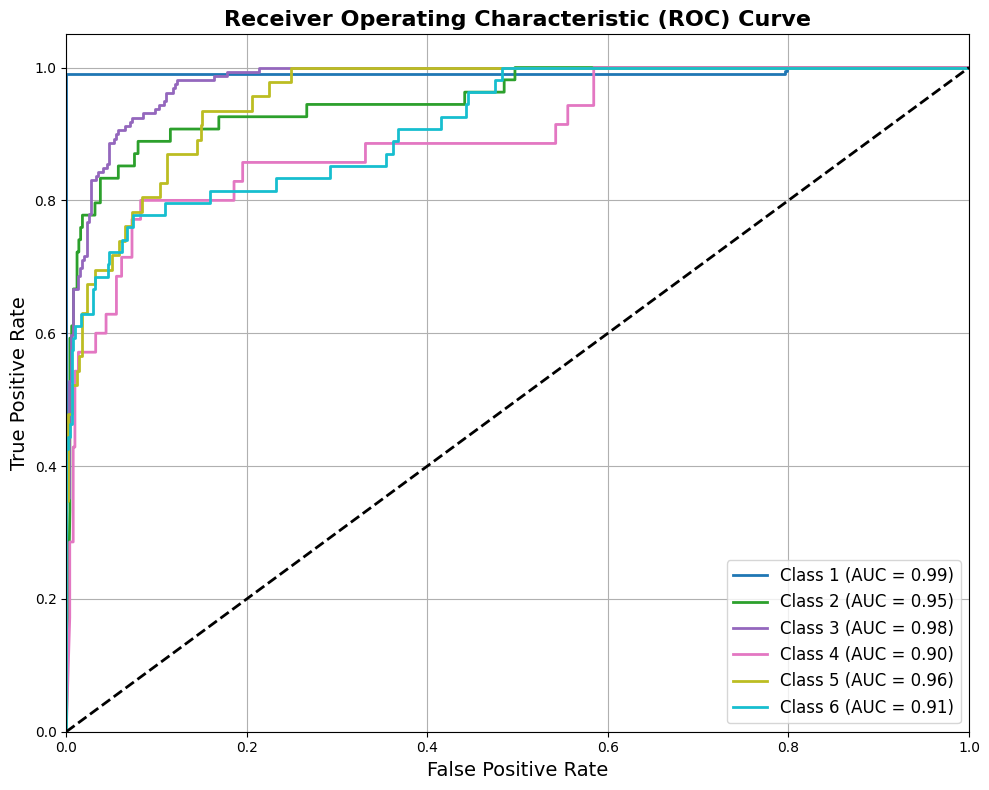

In [5]:
# PLOT ROC

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

y_true = []
y_prob = []

# Run the model on the test data
with torch.no_grad():
    for waveforms, labels in test_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        outputs = model(waveforms)
        probabilities = F.softmax(outputs, dim=1)  # Get probabilities
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Binarize the true labels for ROC curve
from sklearn.preprocessing import label_binarize
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Initialize plot
plt.figure(figsize=(10, 8))

# Colors for the curves
colors = plt.cm.get_cmap('tab10', num_classes)

# Plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(i), lw=2, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (chance line)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()